In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("VN30 Stock Analysis") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

print("Spark version:", spark.version)


Spark version: 3.2.1


In [4]:
df = spark.read.csv("hdfs://namenode:8020/datack/*.csv", header=True, inferSchema=True)

df.show(5)

+--------+------------+------+------+-----+-------+--------+
|<Ticker>|<DTYYYYMMDD>|<Open>|<High>|<Low>|<Close>|<Volume>|
+--------+------------+------+------+-----+-------+--------+
|     REE|    20210625|  56.9|  57.0| 55.8|   56.5|  429400|
|     REE|    20210624|  56.5|  57.0| 56.4|   56.4|  312400|
|     REE|    20210623|  57.6|  57.9| 56.6|   56.9|  692700|
|     REE|    20210622|  58.0|  58.8| 57.3|   57.6|  559600|
|     REE|    20210621|  59.7|  59.3| 57.8|   58.2|  684000|
+--------+------------+------+------+-----+-------+--------+
only showing top 5 rows



In [5]:
df.printSchema()

root
 |-- <Ticker>: string (nullable = true)
 |-- <DTYYYYMMDD>: integer (nullable = true)
 |-- <Open>: double (nullable = true)
 |-- <High>: double (nullable = true)
 |-- <Low>: double (nullable = true)
 |-- <Close>: double (nullable = true)
 |-- <Volume>: integer (nullable = true)



In [10]:
from pyspark.sql.functions import col, round
# Tạo cột phần trăm thay đổi giá mỗi ngày
df = df.withColumn("ChangePct", round((col("<Close>") - col("<Open>")) / col("<Open>") * 100, 2))


In [11]:
df.show(5)

+--------+------------+------+------+-----+-------+--------+---------+
|<Ticker>|<DTYYYYMMDD>|<Open>|<High>|<Low>|<Close>|<Volume>|ChangePct|
+--------+------------+------+------+-----+-------+--------+---------+
|     REE|    20210625|  56.9|  57.0| 55.8|   56.5|  429400|     -0.7|
|     REE|    20210624|  56.5|  57.0| 56.4|   56.4|  312400|    -0.18|
|     REE|    20210623|  57.6|  57.9| 56.6|   56.9|  692700|    -1.22|
|     REE|    20210622|  58.0|  58.8| 57.3|   57.6|  559600|    -0.69|
|     REE|    20210621|  59.7|  59.3| 57.8|   58.2|  684000|    -2.51|
+--------+------------+------+------+-----+-------+--------+---------+
only showing top 5 rows



In [16]:
from pyspark.sql.functions import to_date
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import col
# Chuyển đổi DTYYYYMMDD sang kiểu Date
df = df.withColumn("Date", to_date(col("<DTYYYYMMDD>").cast("string"), "yyyyMMdd"))

# Kiểm tra và xử lý null (nếu có)
df = df.dropna()

# Đảm bảo các cột số là kiểu số (nếu inferSchema sai)
df = df.withColumn("<Close>", col("<Close>").cast(DoubleType())) \
       .withColumn("<Volume>", col("<Volume>").cast(IntegerType()))

df.printSchema()
df.show(5)

root
 |-- <Ticker>: string (nullable = true)
 |-- <DTYYYYMMDD>: integer (nullable = true)
 |-- <Open>: double (nullable = true)
 |-- <High>: double (nullable = true)
 |-- <Low>: double (nullable = true)
 |-- <Close>: double (nullable = true)
 |-- <Volume>: integer (nullable = true)
 |-- ChangePct: double (nullable = true)
 |-- Date: date (nullable = true)

+--------+------------+------+------+-----+-------+--------+---------+----------+
|<Ticker>|<DTYYYYMMDD>|<Open>|<High>|<Low>|<Close>|<Volume>|ChangePct|      Date|
+--------+------------+------+------+-----+-------+--------+---------+----------+
|     REE|    20210625|  56.9|  57.0| 55.8|   56.5|  429400|     -0.7|2021-06-25|
|     REE|    20210624|  56.5|  57.0| 56.4|   56.4|  312400|    -0.18|2021-06-24|
|     REE|    20210623|  57.6|  57.9| 56.6|   56.9|  692700|    -1.22|2021-06-23|
|     REE|    20210622|  58.0|  58.8| 57.3|   57.6|  559600|    -0.69|2021-06-22|
|     REE|    20210621|  59.7|  59.3| 57.8|   58.2|  684000|    -2.

In [17]:
# Tìm giá đóng cửa (Close) trung bình, cao nhất, thấp nhất 
# và khối lượng (Volume) giao dịch trung bình cho từng mã (Ticker).
from pyspark.sql.functions import avg, max, min
basic_stats = df.groupBy("<Ticker>") \
    .agg(
        avg("<Close>").alias("Avg_Close"),
        max("<Close>").alias("Max_Close"),
        min("<Close>").alias("Min_Close"),
        avg("<Volume>").alias("Avg_Volume")
    )
basic_stats.show()

+--------+------------------+---------+---------+------------------+
|<Ticker>|         Avg_Close|Max_Close|Min_Close|        Avg_Volume|
+--------+------------------+---------+---------+------------------+
|     SSI|15.190702662229558|     53.7|   4.1745|2670544.1092623407|
|     SBT|11.576043729323354|  36.6705|   1.8026|1356472.7978947368|
|     PNJ| 31.90247203278712|    101.9|   4.2822|222202.55704918032|
|     MBB|11.821110552555012|     42.1|   3.8988| 3885864.333194848|
|     TCH|20.075031186440693|  43.1156|  12.9066|2465284.2118644067|
|     VNM|46.306322358146765| 132.7491|    2.728| 558889.2277459656|
|     VPB|27.287067289719666|     72.0|    16.95| 5010468.660436137|
|     TPB|19.957316687578437|     39.0|     13.5| 1188471.957340025|
|     VIC|41.922699270711774|    144.0|   2.4293| 639301.5306301051|
|     CTG| 17.79040640724583|     54.0|   8.0049|2583112.8329419657|
|     KDH| 12.63406981331453|    37.35|    2.481| 317416.0852412821|
|     BID|25.824845533297072|  54.

In [18]:
# Tổng khối lượng giao dịch theo mã
from pyspark.sql.functions import sum
print("Tổng khối lượng giao dịch theo mã:")
df.groupBy("<Ticker>").sum("<Volume>").orderBy("sum(<Volume>)", ascending=False).show(10, truncate=False)

Tổng khối lượng giao dịch theo mã:
+--------+-------------+
|<Ticker>|sum(<Volume>)|
+--------+-------------+
|STB     |15510977709  |
|HPG     |11747328818  |
|SSI     |9629982058   |
|MBB     |9353275450   |
|CTG     |7700259355   |
|VPB     |4825081320   |
|SBT     |4510272053   |
|TCB     |4292025940   |
|POW     |3796262502   |
|BID     |3500733380   |
+--------+-------------+
only showing top 10 rows



In [21]:
from pyspark.sql import Window
from pyspark.sql import functions as F
# Ngày tăng mạnh nhất và giảm mạnh nhất của từng mã
window_up = Window.partitionBy("<Ticker>").orderBy(F.desc("ChangePct"))
max_up = df.withColumn("rank", F.row_number().over(window_up)) \
           .filter(F.col("rank") == 1) \
           .select("<Ticker>", "Date", "ChangePct")

window_down = Window.partitionBy("<Ticker>").orderBy(F.asc("ChangePct"))
max_down = df.withColumn("rank", F.row_number().over(window_down)) \
             .filter(F.col("rank") == 1) \
             .select("<Ticker>", "Date", "ChangePct")

print("Ngày tăng mạnh nhất của từng mã:")
max_up.show(10)

print("Ngày giảm mạnh nhất của từng mã:")
max_down.show(10)

Ngày tăng mạnh nhất của từng mã:
+--------+----------+---------+
|<Ticker>|      Date|ChangePct|
+--------+----------+---------+
|     BID|2020-03-17|    10.46|
|     BVH|2021-01-29|    10.78|
|     CTG|2011-05-26|    10.39|
|     FPT|2011-05-26|    10.17|
|     GAS|2012-05-21|    10.81|
|     HDB|2021-01-29|     10.4|
|     HPG|2009-04-21|    10.17|
|     KDH|2013-11-25|    11.11|
|     MBB|2021-01-29|    10.09|
|     MSN|2011-05-26|     10.0|
+--------+----------+---------+
only showing top 10 rows

Ngày giảm mạnh nhất của từng mã:
+--------+----------+---------+
|<Ticker>|      Date|ChangePct|
+--------+----------+---------+
|     BID|2020-03-11|    -9.31|
|     BVH|2018-05-02|    -11.5|
|     CTG|2018-05-02|    -8.25|
|     FPT|2007-01-17|    -8.18|
|     GAS|2020-03-11|    -8.86|
|     HDB|2019-01-02|    -6.93|
|     HPG|2012-09-18|    -7.39|
|     KDH|2014-03-20|    -9.77|
|     MBB|2018-04-26|    -7.32|
|     MSN|2011-01-24|    -9.28|
+--------+----------+---------+
only showing

In [22]:
# Biến động giá (Volatility)
# Tính mức chênh lệch giá cao nhất (High) và thấp nhất (Low) trong ngày để xem mã nào biến động nhiều nhất.
df = df.withColumn("Daily_Spread", col("<High>") - col("<Low>"))
volatility = df.groupBy("<Ticker>") \
    .agg(avg("Daily_Spread").alias("Avg_Daily_Spread")) \
    .orderBy(col("Avg_Daily_Spread").desc())
volatility.show()

+--------+-------------------+
|<Ticker>|   Avg_Daily_Spread|
+--------+-------------------+
|     VJC|    2.4267292051756|
|     VHM| 2.1223289203084876|
|     MSN| 1.6634417643004336|
|     MWG| 1.6611279792746232|
|     GAS| 1.6438412411971839|
|     BVH| 1.5729290387182913|
|     PLX| 1.3748940669856473|
|     NVL| 1.0763658928571438|
|     VIC|  1.007780280046671|
|     VRE| 0.9589857300884957|
|     VCB| 0.9043438649281162|
|     VNM| 0.8757835502342615|
|     VPB| 0.8548030114226376|
|     PNJ| 0.7870733442622919|
|     BID| 0.7636200324851152|
|     TCB| 0.7072265625000006|
|     HDB| 0.6785876157407408|
|     TCH| 0.6722802542372888|
|     TPB|    0.5234991217064|
|     CTG|0.47108802415296813|
+--------+-------------------+
only showing top 20 rows



In [24]:
# Xu hướng theo thời gian (Time-Series Trend)
# Tính giá đóng cửa trung bình của toàn bộ theo từng năm
from pyspark.sql.functions import year
df_with_year = df.withColumn("Year", year(col("Date")))
yearly_trend = df_with_year.groupBy("Year") \
    .agg(avg("<Close>").alias("Avg_Close_VN30")) \
    .orderBy("Year")
yearly_trend.show()

+----+------------------+
|Year|    Avg_Close_VN30|
+----+------------------+
|2000|1.9333151515151519|
|2001|4.1738960264900635|
|2002|2.2026152542372888|
|2003| 1.162368825910932|
|2004|2.1143787999999986|
|2005| 2.578967729083667|
|2006| 7.513624486571885|
|2007|18.716431409295357|
|2008| 7.057379719917011|
|2009| 9.439350379362669|
|2010|13.432002061855673|
|2011| 16.61505988310308|
|2012|15.707345994643289|
|2013| 18.43317929050814|
|2014|20.844829701657456|
|2015|21.675243309260825|
|2016|25.744144405377444|
|2017| 35.03804804362881|
|2018|  48.0773168487395|
|2019| 47.27430332354514|
+----+------------------+
only showing top 20 rows



In [26]:
# Tìm ngày có khối lượng giao dịch cao nhất cho mỗi mã
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("<Ticker>").orderBy(col("<Volume>").desc())

from pyspark.sql.functions import row_number

top_volume_days = df.withColumn("rank", row_number().over(windowSpec)) \
                    .filter(col("rank") == 1) \
                    .select("<Ticker>", "Date", "<Volume>")

top_volume_days.show()

+--------+----------+--------+
|<Ticker>|      Date|<Volume>|
+--------+----------+--------+
|     BID|2017-05-22|15701040|
|     BVH|2020-10-12| 3903200|
|     CTG|2021-05-13|34020000|
|     FPT|2020-05-13| 6853810|
|     GAS|2020-11-18| 3450740|
|     HDB|2018-01-05|32205910|
|     HPG|2021-05-31|60309100|
|     KDH|2021-04-29|11026900|
|     MBB|2021-01-04|42370800|
|     MSN|2020-10-29| 6707870|
|     MWG|2020-04-07| 5818790|
|     NVL|2020-12-29|10563890|
|     PDR|2021-06-14| 8276900|
|     PLX|2021-06-15| 7003300|
|     PNJ|2020-05-12| 2362950|
|     POW|2021-03-05|44357300|
|     REE|2010-03-19| 6673050|
|     SBT|2018-03-14|14317460|
|     SSI|2021-05-20|28128900|
|     STB|2021-03-30|99978500|
+--------+----------+--------+
only showing top 20 rows



In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Cài đặt style cho biểu đồ đẹp hơn
sns.set(style="whitegrid")

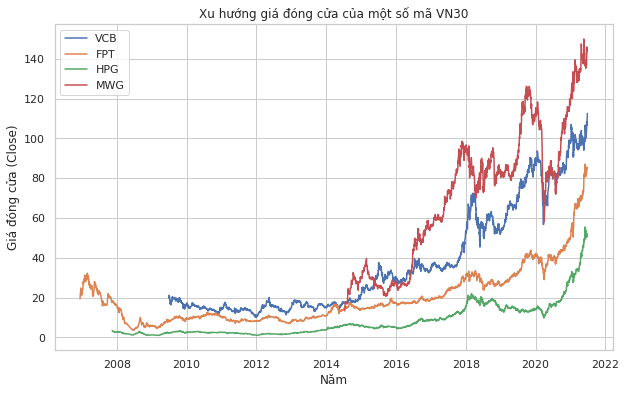

In [42]:
# giá đóng cửa (Close) của một vài mã tiêu biểu: VCB, FPT, HPG, MWG
import pandas as pd
import matplotlib.pyplot as plt

# Chọn 1 vài mã để hiển thị
tickers = ["VCB", "FPT", "HPG", "MWG"]

plt.figure(figsize=(10, 6))
for t in tickers:
    data = df.filter(df["<Ticker>"] == t).select("Date", "<Close>").toPandas()
    data = data.sort_values("Date")
    plt.plot(data["Date"], data["<Close>"], label=t)

plt.title("Xu hướng giá đóng cửa của một số mã VN30")
plt.xlabel("Năm")
plt.ylabel("Giá đóng cửa (Close)")
plt.legend()
plt.grid(True)
plt.show()

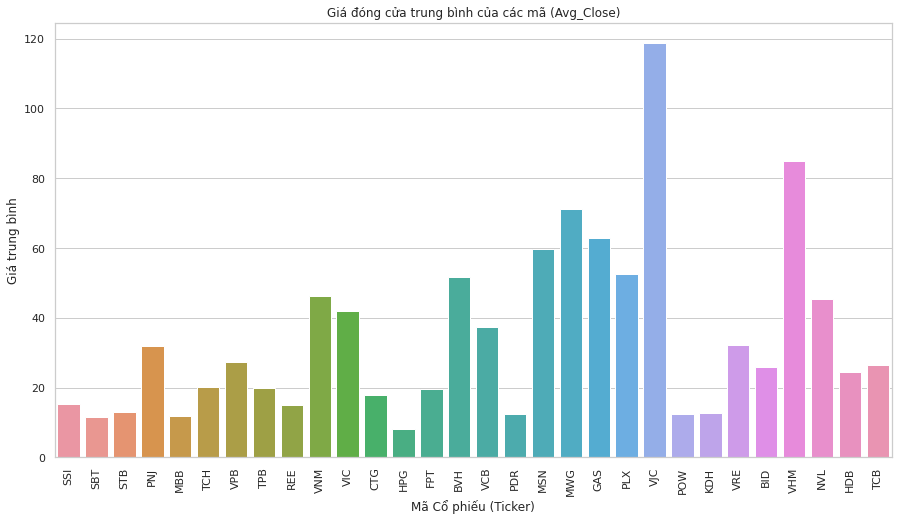

In [29]:
# So sánh Giá đóng cửa Trung bình các mã
basic_stats_pd = basic_stats.toPandas()

plt.figure(figsize=(15, 8))
sns.barplot(data=basic_stats_pd, x="<Ticker>", y="Avg_Close")
plt.title("Giá đóng cửa trung bình của các mã (Avg_Close)")
plt.xlabel("Mã Cổ phiếu (Ticker)")
plt.ylabel("Giá trung bình")
plt.xticks(rotation=90)
plt.show()

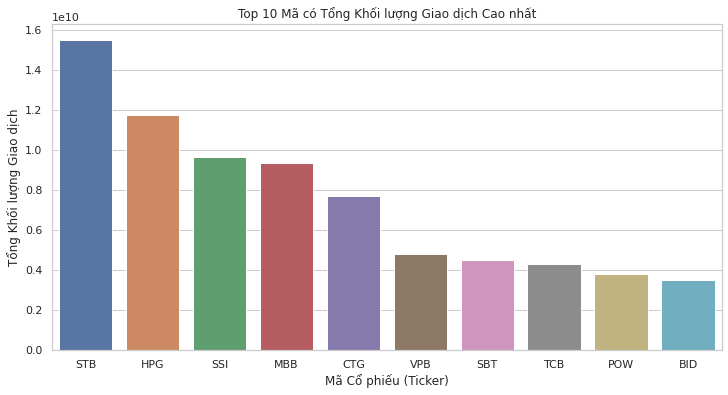

In [30]:
# Lấy 10 mã có khối lượng giao dịch cao nhất
top_10_volume_pd = df.groupBy("<Ticker>") \
                     .sum("<Volume>") \
                     .withColumnRenamed("sum(<Volume>)", "Total_Volume") \
                     .orderBy("Total_Volume", ascending=False) \
                     .limit(10) \
                     .toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_volume_pd, x="<Ticker>", y="Total_Volume")
plt.title("Top 10 Mã có Tổng Khối lượng Giao dịch Cao nhất")
plt.xlabel("Mã Cổ phiếu (Ticker)")
plt.ylabel("Tổng Khối lượng Giao dịch")
plt.show()

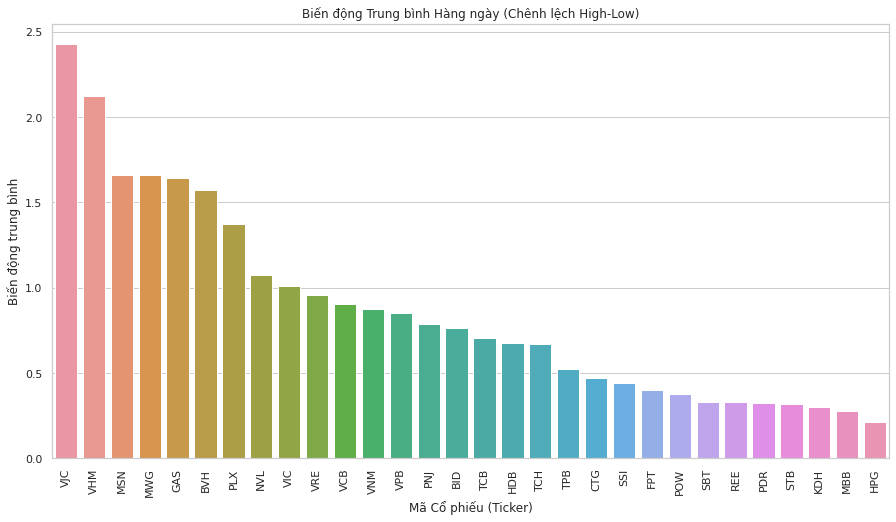

In [31]:
# Biến động trung bình hàng ngày (Volatility)
volatility_pd = volatility.toPandas()

plt.figure(figsize=(15, 8))
sns.barplot(data=volatility_pd, x="<Ticker>", y="Avg_Daily_Spread")
plt.title("Biến động Trung bình Hàng ngày (Chênh lệch High-Low)")
plt.xlabel("Mã Cổ phiếu (Ticker)")
plt.ylabel("Biến động trung bình")
plt.xticks(rotation=90)
plt.show()

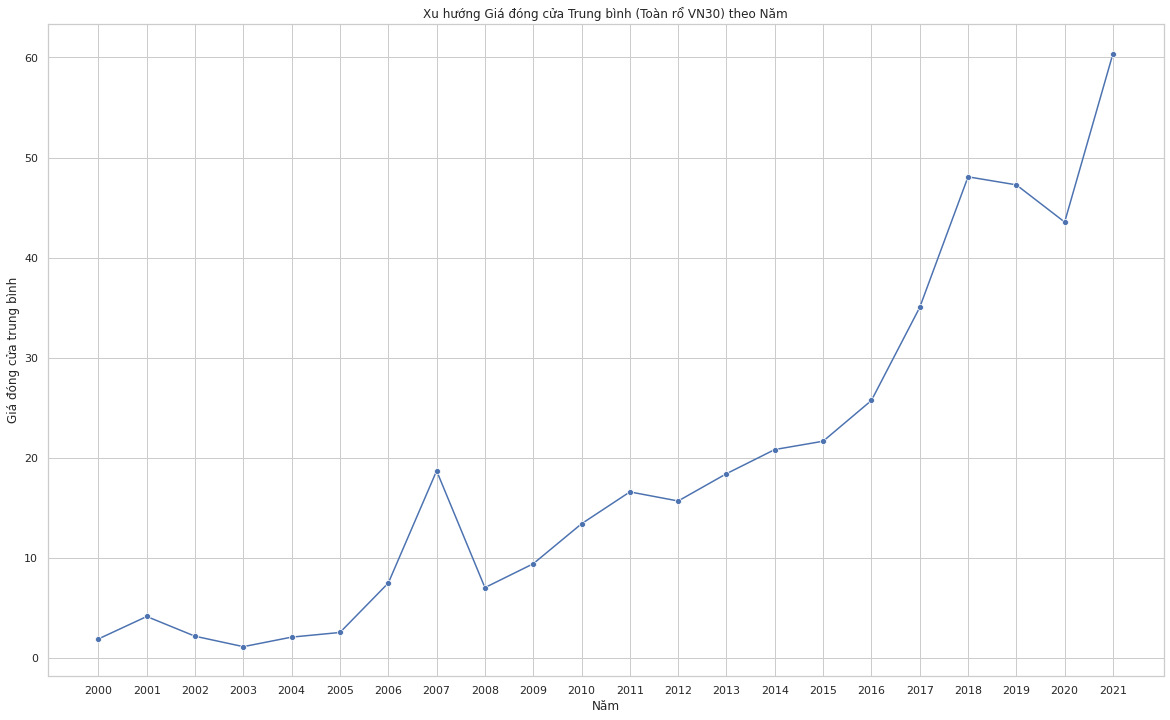

In [34]:
# Xu hướng Giá trung bình toàn thị trường theo Nămyearly_trend_pd = yearly_trend.orderBy("Year").toPandas()
plt.figure(figsize=(20, 12))
sns.lineplot(data=yearly_trend_pd, x="Year", y="Avg_Close_VN30", marker='o')
plt.title("Xu hướng Giá đóng cửa Trung bình (Toàn rổ VN30) theo Năm")
plt.xlabel("Năm")
plt.ylabel("Giá đóng cửa trung bình")
plt.xticks(yearly_trend_pd['Year'].unique()) # Đảm bảo hiển thị đủ các năm
plt.show()

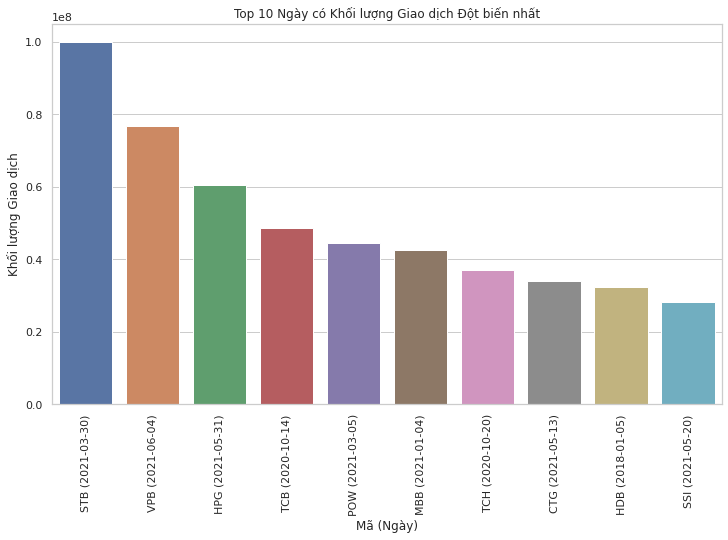

In [35]:
# Ngày có Khối lượng Giao dịch Cao nhất (Top 10)
# Lấy top 10 ngày có volume cao nhất từ kết quả
top_volume_days_pd = top_volume_days.orderBy(col("<Volume>").desc()) \
                                    .limit(10) \
                                    .toPandas()

# Tạo một cột Ticker + Date để dễ đọc hơn
top_volume_days_pd['Ticker_Date'] = top_volume_days_pd['<Ticker>'] + " (" + top_volume_days_pd['Date'].astype(str) + ")"

plt.figure(figsize=(12, 7))
sns.barplot(data=top_volume_days_pd, x="Ticker_Date", y="<Volume>")
plt.title("Top 10 Ngày có Khối lượng Giao dịch Đột biến nhất")
plt.xlabel("Mã (Ngày)")
plt.ylabel("Khối lượng Giao dịch")
plt.xticks(rotation=90)
plt.show()

In [41]:
df.write.csv("hdfs://namenode:8020/user/jovyan/output/vn30_cleaned_final", header=True, mode="overwrite")
